In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")

# Features und Ziel
X = data.drop(columns=["price", "cityname"])
y = data["price"]

# Numerische Spalten
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

# Skalieren
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X["state"] = X["state"].astype("category")
#X["cityname"] = X["cityname"].astype("category")
data.columns


Index(['bathrooms', 'bedrooms', 'has_photo', 'price', 'square_feet',
       'cityname', 'state', 'latitude', 'longitude', 'time', 'pool', 'gym',
       'parking', 'sauna', 'elevator', 'clubhouse', 'source_Andere source',
       'source_GoSection8', 'source_ListedBuy', 'source_RealRentals',
       'source_RentDigs.com', 'source_RentLingo'],
      dtype='object')

Zum Testen welche Features gebraucht werden

In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")

# Features und Ziel
X = data[["square_feet", "state", "cityname", "bedrooms", "bathrooms"]]
y = data["price"]

# Numerische Spalten
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

# Skalieren
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X["state"] = X["state"].astype("category")
X["cityname"] = X["cityname"].astype("category")

C:\Users\User\AppData\Local\Temp\ipykernel_25364\2556976023.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.fit_transform(X[num_cols])
C:\Users\User\AppData\Local\Temp\ipykernel_25364\2556976023.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["state"] = X["state"].astype("category")
C:\Users\User\AppData\Local\Temp\ipykernel_25364\2556976023.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

## 🚀 Hyperparameter des GradientBoostingRegressor

Der **Gradient Boosting Regressor (GBR)** ist eine **sequenzielle Ensemble-Methode**, die schwache Modelle (typischerweise Entscheidungsbäume) iterativ kombiniert. Die Parameter definieren das Suchgitter (`gbr_params`) für die Optimierung in der Nested Cross-Validation.

| Parameter | Beschreibung | Im Code definierte Werte |
| :--- | :--- | :--- |
| **`n_estimators`** | Die **Anzahl der Boosting-Stufen** (Anzahl der sequenziell hinzugefügten schwachen Lerner, d.h. Bäume). | `[5, 50]` |
| **`learning_rate`** | Die **Schrumpfungsrate** ($\eta$). Skaliert den Beitrag jedes Baumes. Ein kleinerer Wert erfordert mehr `n_estimators`, verbessert aber oft die Generalisierung. | `[0.1, 0.2]` |
| **`max_depth`** | Die **maximale Tiefe** jedes einzelnen Entscheidungsbaums (des *schwachen Lerners*). GBR verwendet meist flache Bäume (z.B. Tiefe 3-5). | `[3, 5, 7]` |
| **`min_samples_split`** | Die **minimale Anzahl von Datenpunkten** in einem internen Knoten, die für eine Teilung erforderlich ist. Dient zur Kontrolle der Baumkomplexität. | `[5, 10]` |

---

### 💡 Erläuterung der Boosting-Strategie



Gradient Boosting arbeitet, indem es sequentielle Bäume aufbaut, wobei jeder neue Baum versucht, die **Restfehler** (Residuen) des vorherigen Ensembles zu korrigieren.

1.  **`n_estimators`** und **`learning_rate`** steuern zusammen die **Gesamtstärke** des Modells und die Geschwindigkeit des Lernprozesses.
2.  **`max_depth`** und **`min_samples_split`** steuern die **Komplexität** jedes einzelnen, schwachen Entscheidungsbaums, der zur Korrektur der Residuen verwendet wird.

Starte XGBoost Nested CV...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=300; total time=   7.5s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=300; total time=   7.1s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=300; total time=   7.1s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=300; total time=   7.0s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=300; total time=   7.1s
Outer Fold 1/5 | Best Params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300} | Fit Time: 7.303s | Outer R²: 0.811 | MSE: 89655.588
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=300; total time=   8.0s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=300; total time=   7.0s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=300; total time=   6.8s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=300; 

c:\Users\User\Git\DataProject-WS-25-26\Nested_CV.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


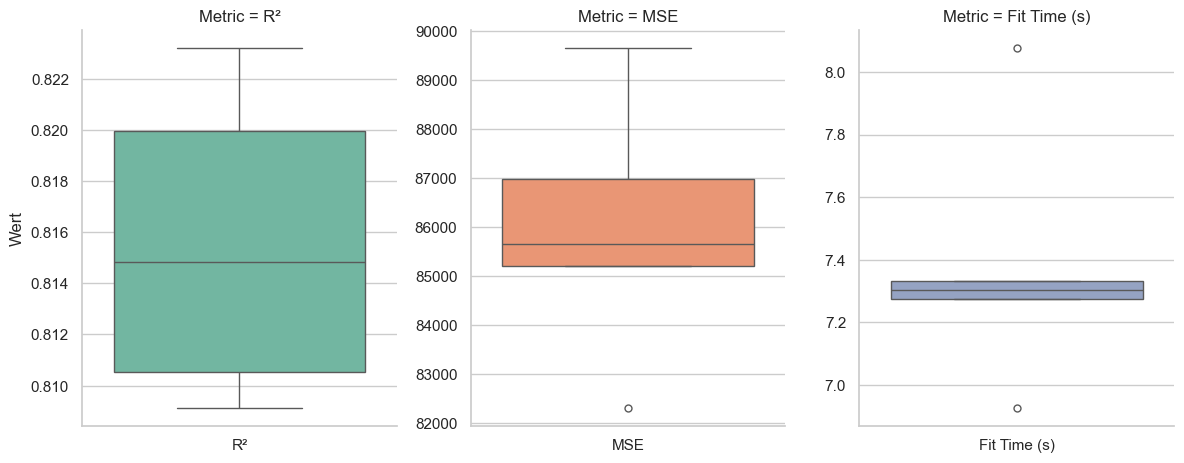


--- XGBoost Ergebnisse ---
Mean R²: 0.8155322105040421
Best params: [{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}, {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}, {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}, {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}, {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}]


In [34]:
from Nested_CV import NestedCVRegressor
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    random_state=42,
    n_jobs=-1,
    enable_categorical=True
    # alle CPU-Kerne nutzen
)

# Hyperparameter-Grid
xgb_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1, 0.2],
    #"subsample": [0.8, 1.0],
    #"colsample_bytree": [0.8, 1.0],
    #"gamma": [0, 1],  # Minimum Loss Reduction
    #"reg_alpha": [0, 0.1],  # L1 Regularisierung
    #"reg_lambda": [1, 5]    # L2 Regularisierung
}
xgb_params =  {
    "n_estimators": [300],
    "max_depth": [7],
    "learning_rate": [0.2],
    #"subsample": [0.8, 1.0],
    #"colsample_bytree": [0.8, 1.0],
    #"gamma": [0, 1],  # Minimum Loss Reduction
    #"reg_alpha": [0, 0.1],  # L1 Regularisierung
    #"reg_lambda": [1, 5]    # L2 Regularisierung
}

xgb_cv = NestedCVRegressor(xgb_model, xgb_params)

print("Starte XGBoost Nested CV...")
xgb_cv.run(X, y, output=True)

xgb_cv.plot_scores("XGBoost Nested CV")

print("\n--- XGBoost Ergebnisse ---")
print("Mean R²:", xgb_cv.get_mean_r2())
print("Best params:", xgb_cv.get_best_params())


In [14]:
number_outer_cv_splits = 5
model_evaluation = pd.DataFrame({"Fold": range(1, number_outer_cv_splits+1)})
model_evaluation['Modell'] = ['XGBOOST_sparse'] * number_outer_cv_splits
model_evaluation['R_2'] = xgb_cv.get_r2_scores()
model_evaluation['MSE'] = xgb_cv.get_mse_scores()
model_evaluation["runtime"] = xgb_cv.get_fit_times()
model_evaluation

,Fold,Modell,R_2,MSE,runtime
0,1,XGBOOST_sparse,0.859577,66440.826764,10.099447
1,2,XGBOOST_sparse,0.868789,61096.930158,8.470244
2,3,XGBOOST_sparse,0.861390,64131.956331,10.598911
3,4,XGBOOST_sparse,0.863201,64751.222842,9.200722
4,5,XGBOOST_sparse,0.857434,64978.025189,12.669397


In [15]:
model_evaluation.to_pickle('benchmarking/XGBOOST_sparsedata.pkl')

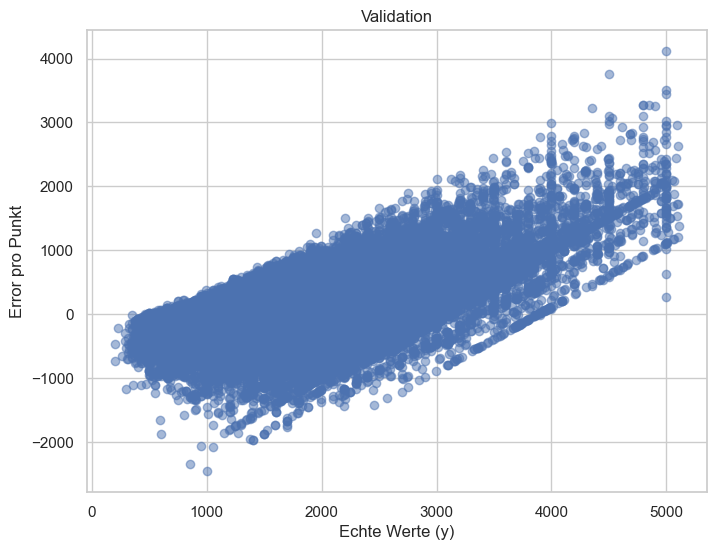

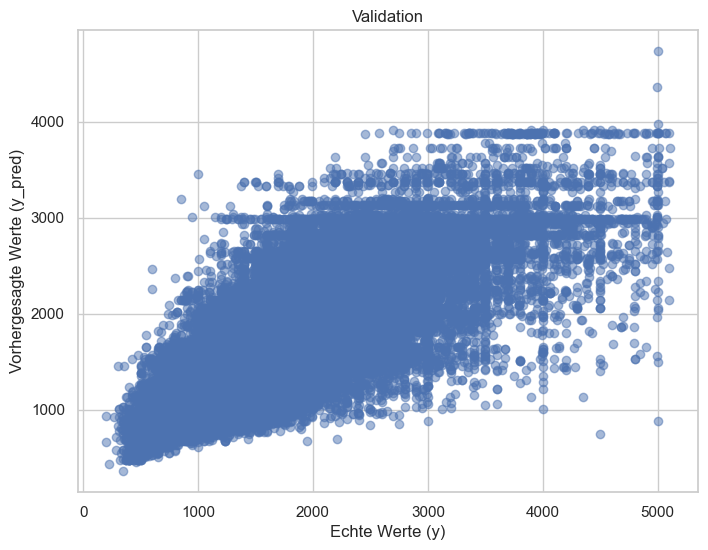

In [24]:
best_params = {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
xgb_final_model = xgb.XGBRegressor(
    objective='reg:squarederror', learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'],
    random_state=42, n_jobs=-1, enable_categorical=True)
xgb_final_model.fit(X, y)
# Vorhersagen
y_pred = xgb_final_model.predict(X)

import matplotlib.pyplot as plt
# RMSE pro Punkt (Absolutfehler oder quadratischer Fehler)
rmse_per_point = (y - y_pred)  # = |y_i - y_pred_i|

# Plot
plt.figure(figsize=(8,6))
plt.scatter(y, rmse_per_point, alpha=0.5)
plt.xlabel("Echte Werte (y)")
plt.ylabel("Error pro Punkt")
plt.title("Validation")
plt.grid(True)
plt.show()
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.5)
plt.xlabel("Echte Werte (y)")
plt.ylabel("Vorhergesagte Werte (y_pred)")
plt.title("Validation")
plt.grid(True)
plt.show()

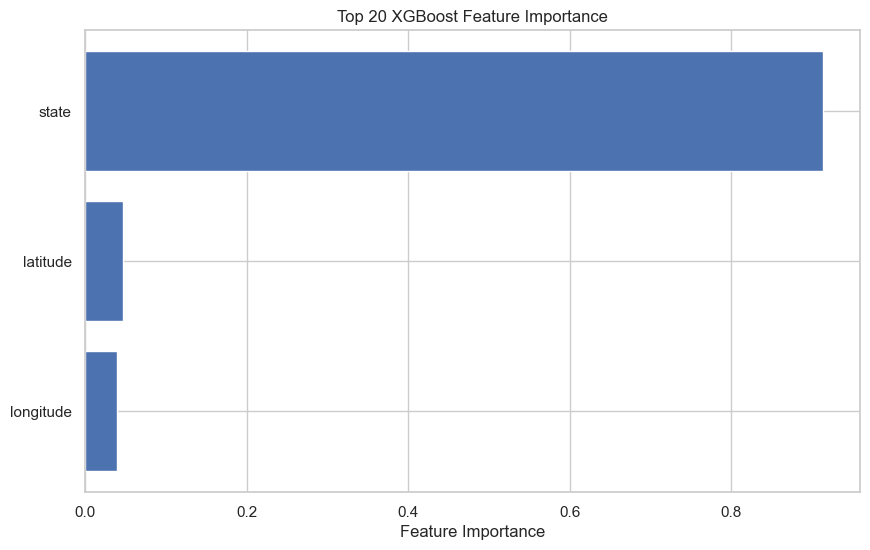

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Feature Importances
importances = xgb_final_model.feature_importances_

# Sortiere Indizes nach Wichtigkeit absteigend
indices = np.argsort(importances)[::-1]

# Nur die Top 20
top_n = 20
top_indices = indices[:top_n]
top_features = [X.columns[i] for i in top_indices]
top_importances = importances[top_indices]

# Barplot
plt.figure(figsize=(10,6))
plt.barh(top_features[::-1], top_importances[::-1])  # umgekehrt für höchste oben
plt.xlabel("Feature Importance")
plt.title("Top 20 XGBoost Feature Importance")
plt.show()



In [26]:
import seaborn as sns
# X ist dein Feature-Matrix (DataFrame oder np.array)
# columns = Liste aller Spaltennamen
state_columns = [col for col in features if col.startswith("state_")]

# Index der aktiven Spalte pro Zeile = die Stadt
state_index = data[state_columns].values.argmax(axis=1)

# Map zu Stadtname
state_names = [col.replace("state_", "") for col in state_columns]
df_states = pd.Series([state_names[i] for i in state_index], name="Stadt")

# Vorhersagen
y_pred = xgb_final_model.predict(X)

# Fehler
residuals = np.abs(y - y_pred)

# DataFrame für Analyse
df_plot = pd.DataFrame({
    "y_true": y,
    "y_pred": y_pred,
    "residual": residuals,
    "Stadt": df_states
})
top_states = df_plot['Stadt'].value_counts().head(20).index
df_top = df_plot[df_plot['Stadt'].isin(top_states)]

plt.figure(figsize=(12,6))
sns.boxplot(x="Stadt", y="y_true", data=df_top)
plt.xticks(rotation=45)
plt.show()



NameError: name 'features' is not defined